# Prototyping LSTm

Introduction: what we need to know to implement LSTM for time series forecasting:

LSTM expects 3D input -- (samples, time_steps, features)
- num of sequences
- how many past timesteps are being fed
- number of features per timestep

Pick:
- Appropriate window size (96 steps = 1 day ahead for 15 min intervals)
- Multistep forecasting - can do many-to-one (predict a single future value) OR many-to-many (predict a sequence of future values e.g. demand for the next 30 days)

Input features:
- Historical demand (target)
- Exogenous inputs
- Time-based features (hour/day/month as sin/cos)
- ** syncronize and scale with MinMaxScaler or StandardScaler

Architecture:
- Stack several LSTM layers, Dropout for regularization, final Dense layer with correct number of outputs for prediction type (one or many!)

Training setup:
- Loss function: MAE or MSE
- Optimizer (start with Adam)
- Early stopping and learning rate hyperparameters

Validation:
- Time-based split (no shuffling)
- Forecasting performance evaluated separately on day-ahead; 7-days-ahead; 30-day-ahead

In [18]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 MB 16.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 24.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.5/639.5 kB 16.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

2025-05-02 12:02:55.308203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
df = pd.read_csv('../data/processed/merged_dataset_cleaned.csv', sep = ';', index_col = 'utc_timestamp', parse_dates = True)

print(df.head())
print(df.tail())
print(df.dtypes)
print(df.isnull().sum())
print(df.info())

                                 cet_cest_timestamp  \
utc_timestamp                                         
2015-01-01 07:15:00+00:00  2015-01-01T08:15:00+0100   
2015-01-01 07:30:00+00:00  2015-01-01T08:30:00+0100   
2015-01-01 07:45:00+00:00  2015-01-01T08:45:00+0100   
2015-01-01 08:00:00+00:00  2015-01-01T09:00:00+0100   
2015-01-01 08:15:00+00:00  2015-01-01T09:15:00+0100   

                           DE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2015-01-01 07:15:00+00:00                            40998.20   
2015-01-01 07:30:00+00:00                            41120.90   
2015-01-01 07:45:00+00:00                            41476.39   
2015-01-01 08:00:00+00:00                            42120.40   
2015-01-01 08:15:00+00:00                            42624.45   

                           DE_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2015-01-01 07:15:00+00:0

## Select + Clean Input Features
- Drop timestamps (hour and month is sufficient) - in the future, think about adding holiday stamps and weekdays
- Convert object columns to numeric (float) - I will not include these predictors in the first round, because I'm sick of missing value imputation, but it is something to look into

In [40]:
# Subsampling on 2019 data
df = df.loc['2019-01-01':'2019-12-31']

In [43]:
# Drop time columns
df = df.drop(columns=["cet_cest_timestamp"])

# Convert radiation columns to numeric (SKIPPED)
#df['DE_radiation_direct_horizontal'] = pd.to_numeric(df['DE_radiation_direct_horizontal'], errors='coerce')
#df['DE_radiation_diffuse_horizontal'] = pd.to_numeric(df['DE_radiation_diffuse_horizontal'], errors='coerce')

df = df.drop(columns=["DE_radiation_direct_horizontal", "DE_radiation_diffuse_horizontal"])


In [44]:
# Remove utc_timestamp as index
df = df.reset_index()
# Remove utc_timestamp column
df = df.drop(columns=["utc_timestamp"])

In [46]:
print(df.dtypes)
print(df.isnull().sum())

DE_load_actual_entsoe_transparency      float64
DE_load_forecast_entsoe_transparency    float64
DE_solar_capacity                         int64
DE_solar_generation_actual              float64
DE_solar_profile                        float64
DE_wind_capacity                          int64
DE_wind_generation_actual               float64
DE_wind_profile                         float64
DE_wind_offshore_capacity                 int64
DE_wind_offshore_generation_actual      float64
DE_wind_offshore_profile                float64
DE_wind_onshore_capacity                  int64
DE_wind_onshore_generation_actual       float64
DE_wind_onshore_profile                 float64
DE_temperature                          float64
hour                                    float64
is_daylight                               int64
month                                     int64
dtype: object
DE_load_actual_entsoe_transparency      0
DE_load_forecast_entsoe_transparency    0
DE_solar_capacity                     

In [48]:
# drop all the profile columns and forecast
df = df.drop(columns=["DE_load_forecast_entsoe_transparency", "DE_solar_profile", "DE_wind_profile", "DE_wind_offshore_profile", "DE_wind_onshore_profile"])

In [50]:
print(df.dtypes)
print(df.isnull().sum())

DE_load_actual_entsoe_transparency    float64
DE_solar_capacity                       int64
DE_solar_generation_actual            float64
DE_wind_capacity                        int64
DE_wind_generation_actual             float64
DE_wind_offshore_capacity               int64
DE_wind_offshore_generation_actual    float64
DE_wind_onshore_capacity                int64
DE_wind_onshore_generation_actual     float64
DE_temperature                        float64
hour                                  float64
is_daylight                             int64
month                                   int64
dtype: object
DE_load_actual_entsoe_transparency    0
DE_solar_capacity                     0
DE_solar_generation_actual            0
DE_wind_capacity                      0
DE_wind_generation_actual             0
DE_wind_offshore_capacity             0
DE_wind_offshore_generation_actual    0
DE_wind_onshore_capacity              0
DE_wind_onshore_generation_actual     0
DE_temperature              

## Normalize Features
- Investigate other scaling strategies during hypertuning i.e. StandardScaler

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)  # `df` is your cleaned DataFrame

## Sequences for LSTM

In [53]:
def create_lstm_sequences(data, input_window = 96, forecast_horizon=96, target_col=0):
    X, y = [], []
    for i in range(len(data) - input_window - forecast_horizon):
        X_seq = data[i:i + input_window]
        y_seq = data[i + input_window:i + input_window + forecast_horizon, target_col]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# target_col = 0 assumes that DE_load_actual is the first column!
# this sets the default to a 1 day ahead forecast

## Build and Compile LSTM Model

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape, forecast_horizon):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))  # (time_steps, features)
    model.add(Dropout(0.2))
    model.add(Dense(forecast_horizon))  # One output per future step

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [55]:
# Let's assume:
# input_window = 96 (past 24h)
# forecast_horizon = 2880 (30 days)
# n_features = 13 (from your data)

input_shape = (96, 13)
forecast_horizon = 2880

model = build_lstm_model(input_shape, forecast_horizon)
model.summary()


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2880)           │       187,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,168 (809.25 KB)

 Trainable params: 207,168 (809.25 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [56]:
X, y = create_lstm_sequences(
    scaled_data,
    input_window=96,
    forecast_horizon=2880, #?
    target_col=0  # Assuming DE_load_actual is the first column
)

In [57]:
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


In [60]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 0.0572 - mae: 0.1845 - val_loss: 0.0232 - val_mae: 0.1283
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0184 - mae: 0.1085 - val_loss: 0.0196 - val_mae: 0.1168
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.0170 - mae: 0.1033 - val_loss: 0.0186 - val_mae: 0.1122
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.0153 - mae: 0.0972 - val_loss: 0.0184 - val_mae: 0.1108
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0142 - mae: 0.0926 - val_loss: 0.0186 - val_mae: 0.1111
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0132 - mae: 0.0885 - val_loss: 0.0172 - val_mae: 0.1066
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.0127 - mae: 0.0860 - val_loss: 0.0175 - val_mae: 0.1070
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - loss: 0.0121 - mae: 0.0837 - val_loss: 0.0171 - val_mae: 0.1052
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 

## Performance Visualization

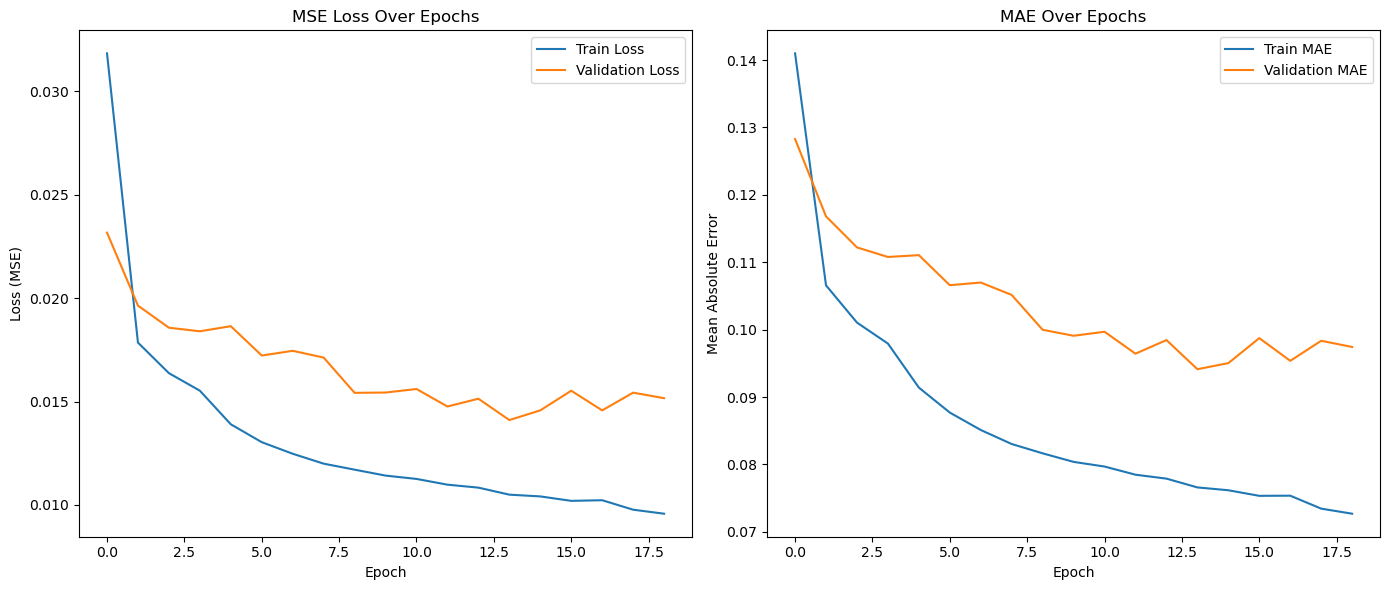

In [62]:
def plot_training_history(history):
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MSE Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)

- No overfitting spike yet
- Good generalization
- Meaningful patterns, not memorizing noise

Next steps:
- Hyperparameter tuning
- Try for entire dataset
- Similar or separate hyperparameter tuning for 3 time horizons?
- Try the other two time horizons
- Plot actual vs. predicted 30 day curves
- Model prototyping with TFT
- Plot 30 day curves?

Keep in mind for the future
- Include more features - holiday stamps, radiation, weekend stamps
- Significance testing - where? Compare model differences?

FIRST!!
- FIX DATASET ONCE AND FOR ALL
- FIGURE OUT HOW TO USE THE WORKFLOW
- START WITH PROTOTYPING ONE TFT HERE, THEN FIX EVERYTHING!!

Upcoming timeline:
Phase 1: Baseline Maturity
1) Baseline LSTM on 2019
2) Full dataset (verify model scales and performance remains stable)
3) Evaluate on test set and plot 30-day predictions (real vs. predicted)
4) Try short/medium/long term horizons
5) Decide on hyperparameter tuning strategy -- shared across horizons if LSTM architecture remains the same, separate if horizons need significantly different model behavior. Use random search or optuna!
6) Hyperparameter tuning (after full-data trials)

Phase 2: Model Prototyping with TFT
1) Prepare TFT input format
2) Run TFT on short- medium- long-term forecasts
3) Plot 30-day curves for TFT
4) Compare evaluation metrics vs. LSTM across horizons

# Prototyping TFT

In [2]:
!pip install torch pytorch-lightning pytorch-forecasting

  Using cached torch-2.2.2-cp312-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl.metadata (20 kB)
  Using cached pytorch_forecasting-1.3.0-py3-none-any.whl.metadata (13 kB)
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached lightning-2.5.1.post0-py3-none-any.whl.metadata (39 kB)
Using cached torch-2.2.2-cp312-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl (823 kB)
Using cached pytorch_forecasting-1.3.0-py3-none-any.whl (197 kB)
Using cached lightning-2.5.1.post0-py3-none-any.whl (819 kB)
Using cached lightning_utilities-0.14.3-py3-none-any.whl (28 kB)
Using cached torchmetrics-1.7.1-py3-none-any.whl (961 kB)


In [2]:
from pytorch_forecasting import TimeSeriesDataSet

TimeSeriesDataset format: special columns
- time_idx - inc. integer as time index
- group_id - ID for each time series group (?)
- target
- known_covariates (features known into the future)
- observed_covariates (features only known up to prediction time - weather, demand, history)

In [3]:
df_TFT = pd.read_csv('../data/processed/merged_dataset_cleaned.csv', sep = ';', index_col = 'utc_timestamp', parse_dates = True)
df_TFT = df_TFT.loc['2019-01-01':'2019-12-31']

print(df_TFT.head())
print(df_TFT.tail())
print(df_TFT.shape)
print(df_TFT.dtypes)
print(df_TFT.isnull().sum())

                                 cet_cest_timestamp  \
utc_timestamp                                         
2019-01-01 00:00:00+00:00  2019-01-01T01:00:00+0100   
2019-01-01 00:15:00+00:00  2019-01-01T01:15:00+0100   
2019-01-01 00:30:00+00:00  2019-01-01T01:30:00+0100   
2019-01-01 00:45:00+00:00  2019-01-01T01:45:00+0100   
2019-01-01 01:00:00+00:00  2019-01-01T02:00:00+0100   

                           DE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2019-01-01 00:00:00+00:00                            42254.95   
2019-01-01 00:15:00+00:00                            41718.84   
2019-01-01 00:30:00+00:00                            41349.07   
2019-01-01 00:45:00+00:00                            40924.25   
2019-01-01 01:00:00+00:00                            40984.90   

                           DE_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2019-01-01 00:00:00+00:0

## Preprocessing

In [5]:
df_TFT.columns

Index(['cet_cest_timestamp', 'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'hour', 'is_daylight', 'month'],
      dtype='object')

In [4]:
# Drop forecasting, radiation, cet timestamp, and all profile columns
cols_to_drop = [
    "cet_cest_timestamp",
    "DE_load_forecast_entsoe_transparency",
    "DE_radiation_direct_horizontal",
    "DE_radiation_diffuse_horizontal",
    "DE_solar_profile",
    "DE_wind_profile",
    "DE_wind_offshore_profile",
    "DE_wind_onshore_profile"
]

df_TFT = df_TFT.drop(columns=cols_to_drop)


In [7]:
df_TFT.shape

(34940, 13)

In [6]:
print(df_TFT.dtypes)
df_TFT.isnull().sum()

DE_load_actual_entsoe_transparency    float64
DE_solar_capacity                       int64
DE_solar_generation_actual            float64
DE_wind_capacity                        int64
DE_wind_generation_actual             float64
DE_wind_offshore_capacity               int64
DE_wind_offshore_generation_actual    float64
DE_wind_onshore_capacity                int64
DE_wind_onshore_generation_actual     float64
DE_temperature                        float64
hour                                  float64
is_daylight                             int64
month                                   int64
dtype: object


DE_load_actual_entsoe_transparency    0
DE_solar_capacity                     0
DE_solar_generation_actual            0
DE_wind_capacity                      0
DE_wind_generation_actual             0
DE_wind_offshore_capacity             0
DE_wind_offshore_generation_actual    0
DE_wind_onshore_capacity              0
DE_wind_onshore_generation_actual     0
DE_temperature                        0
hour                                  0
is_daylight                           0
month                                 0
dtype: int64

In [5]:
df_TFT=df_TFT.copy()
df_TFT["time_idx"] = range(len(df_TFT)) # sequential time index
df_TFT["group_id"] = "DE" # only one group
df_TFT["target"] = df_TFT["DE_load_actual_entsoe_transparency"] # target variable

In [11]:
print(df_TFT.head())

                           DE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2019-01-01 00:00:00+00:00                            42254.95   
2019-01-01 00:15:00+00:00                            41718.84   
2019-01-01 00:30:00+00:00                            41349.07   
2019-01-01 00:45:00+00:00                            40924.25   
2019-01-01 01:00:00+00:00                            40984.90   

                           DE_solar_capacity  DE_solar_generation_actual  \
utc_timestamp                                                              
2019-01-01 00:00:00+00:00              47480                         0.0   
2019-01-01 00:15:00+00:00              47480                         0.0   
2019-01-01 00:30:00+00:00              47480                         0.0   
2019-01-01 00:45:00+00:00              47480                         0.0   
2019-01-01 01:00:00+00:00              47480                         0.0   

           

## Create TimeSeriesDataSet

In [6]:
max_encoder_length = 96      # past 1 day (15-min intervals)
max_prediction_length = 2880 # future 30 days

categorical_columns = ["month", "hour", "is_daylight"]
continuous_columns = [
    "DE_solar_capacity", "DE_solar_generation_actual",
    "DE_wind_capacity", "DE_wind_generation_actual", 
    "DE_wind_offshore_capacity", "DE_wind_offshore_generation_actual", 
    "DE_wind_onshore_capacity", "DE_wind_onshore_generation_actual", 
    "DE_temperature"
]

In [7]:
df_TFT_small = df_TFT.iloc[:10000].copy()

training_dataset = TimeSeriesDataSet(
    df_TFT_small,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=96,
    max_prediction_length=672,  # 7 days
    time_varying_known_reals=["time_idx"] + categorical_columns,
    time_varying_unknown_reals=["target"] + continuous_columns,
    static_categoricals=["group_id"],
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
)


: 

Troubleshooting next step:
- figure out how to create a kernel just for the model
- try running on a PY file